# 1.1: Finalize Study Area for Cross-Validation and External Holdout

**Objective:** To formally define, delineate, and justify the spatial extents for the project's two-tiered validation framework. This script delineates:
1. **Cross-Validation Provinces:** The five core geomorphic provinces that will be used for rigorous internal model development and evaluation using a Leave-One-Province-Out Spatial Cross-Validation (LOPO-SCV) strategy.
2. **External Holdout Province:** A geographically distant and geomorphically distinct province reserved for a final, one-shot test of the model's ability to transfer to a completely novel environment.

This script is the foundational data processing step, ensuring all subsequent analyses are based on a consistent and well-defined set of geographies.

**Justification for Selections:** The selection of these specific provinces and the two-tiered validation design provides the most rigorous and defensible test of the project's core hypotheses.
1. **To Test H1 (Landscape Characterization):** The five cross-validation provinces encompass a wide range of geomorphic expressions. Using a LOPO-SCV design—where the model is trained on four provinces and tested on the fifth, repeated for all five—directly and robustly tests the hypothesis that TLSPs can generate statistically distinct signatures for different landscape types.
2. **To Test H2 (Process Prediction):** Training and evaluating the predictive erosion models within the LOPO-SCV framework provides a powerful estimate of model performance on unseen regions. This guards against spatial autocorrelation and yields a more realistic measure of generalization than traditional random splits.
3. **To Test Final Transferability:** Holding out the entire Basin and Range province as a final, untouched external test provides a critical "reality check." It assesses whether the model has learned fundamental geomorphic principles or simply relationships specific to the Appalachian region, directly testing its conceptual transferability.

In [ ]:
# === 1. Setup and Configuration ===

# --- Core Libraries (pre-geospatial) ---
from __future__ import annotations
import sys
import os
import yaml
import logging
from pathlib import Path
import pyproj

# --- Robust Path Resolution & Config Loading ---
def find_project_root(marker='config.yml'):
    """Find the project root by searching upwards for a marker file."""
    path = Path.cwd().resolve()
    while path.parent != path:
        if (path / marker).exists():
            return path
        path = path.parent
    raise FileNotFoundError(f"Project root with marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# --- Add project's src directory to path and import project modules ---
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from geo_tda.geoio_utils import write_provenance
from geo_tda.geoio_utils.vector import load_and_standardize, write_vector
from geo_tda.geoio_utils.raster import ensure_crs, fix_invalid
from geo_tda.utils import setup_colored_logging
from geo_tda.plotting_utils import create_area_map, create_interactive_map
from geo_tda.qaqc import crs_policy_check, geometry_validity_report, leakage_gap_check, duplicate_names_check

setup_colored_logging()
log = logging.getLogger("1.1_finalize_study_areas")

# --- Environment Configuration for PROJ ---
# This MUST be done before importing geopandas
try:
    pyproj_datadir = pyproj.datadir.get_data_dir()
    os.environ['PROJ_LIB'] = pyproj_datadir
    log.info(f"PROJ_LIB environment variable set to: {pyproj_datadir}")
except Exception as e:
    log.warning(f"Could not set PROJ_LIB automatically. This may cause CRS errors. {e}")

# --- Geospatial & Other Libraries ---
import geopandas as gpd
import pandas as pd
import pyogrio
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import set_precision, union_all
from shapely.validation import make_valid

# --- Configuration Loading ---
CONFIG_PATH = PROJECT_ROOT / "config.yml"
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

# --- Path Configuration ---
RAW_DIR = PROJECT_ROOT / config['paths']['raw_dir']
PROC_DIR = PROJECT_ROOT / config['paths']['processed_dir']
MAPS_DIR = PROJECT_ROOT / 'outputs' / 'maps'
PROC_DIR.mkdir(parents=True, exist_ok=True)
MAPS_DIR.mkdir(parents=True, exist_ok=True)

# Input Path
PROVINCES_GPKG_IN = PROJECT_ROOT / Path(config['paths']['provinces_input'])

# Output Paths
STUDY_AREAS_GPKG_OUT = PROC_DIR / Path(config['paths']['study_areas']).name
EXTERNAL_HOLDOUT_GPKG_OUT = PROC_DIR / Path(config['paths']['external_holdout']).name

# --- Study Area Selection (from config) ---
CV_PROVINCE_NAMES = config['study_area_selection']['cv_provinces']
HOLDOUT_PROVINCE_NAME = config['study_area_selection']['external_holdout_province']

log.info("--- Configuration Summary ---")
log.info(f"Project Root:      {PROJECT_ROOT}")
log.info(f"Input Provinces:   {PROVINCES_GPKG_IN}")
log.info(f"Output CV Areas:   {STUDY_AREAS_GPKG_OUT}")
log.info(f"Output Holdout:    {EXTERNAL_HOLDOUT_GPKG_OUT}")
log.info(f"Target CV Provinces: {len(CV_PROVINCE_NAMES)}")
log.info(f"Target Holdout:    {HOLDOUT_PROVINCE_NAME}")
log.info("Setup complete.")

In [6]:
# === 2. Constants and Helper Functions ===

# --- CRS & Processing Parameters (from config) ---
CV_PROVINCES_CANON = sorted(CV_PROVINCE_NAMES)
PROCESSING_CRS = config['parameters']['processing_crs']
BORDER_GAP_M = config['parameters']['border_gap_m']
OVERLAP_AREA_TOL_M2 = config['parameters']['overlap_area_tol_m2']
PRECISION_GRID_SIZE = config['parameters']['precision_grid_size']

# --- Derived Paths ---
LOPO_GPKG = PROC_DIR / "lopo_folds.gpkg"
LOPO_MANIFEST_CSV = PROC_DIR / "lopo_manifest.csv"
STATIC_MAP_PATH = MAPS_DIR / "study_areas_static_map.png"
INTERACTIVE_MAP_PATH = MAPS_DIR / "study_areas_interactive_map.html"
SOURCE_PATH = PROVINCES_GPKG_IN

# --- Helper Functions ---
def enforce_partition_by_order(input_gdf: gpd.GeoDataFrame, order: list[str], grid_size: float) -> gpd.GeoDataFrame:
    """
    Force polygons to be a non-overlapping partition by subtracting the accumulated
    union of earlier provinces from each subsequent province.
    """
    work = input_gdf.copy()
    work["geometry"] = work.geometry.apply(lambda g: set_precision(g, grid_size))
    work = fix_invalid(work, buffer_zero=True)
    work = work.dissolve(by="PROVINCE", as_index=False)

    accum = None
    out_geoms = {}
    for prov in order:
        if work.loc[work["PROVINCE"] == prov].empty:
            raise ValueError(f"Province '{prov}' not found in the dissolved GeoDataFrame. Check for name mismatches.")

        geom = work.loc[work["PROVINCE"] == prov, "geometry"].values[0]
        if accum is not None and not accum.is_empty:
            geom = geom.difference(accum)
        geom = make_valid(set_precision(geom, grid_size))
        out_geoms[prov] = geom
        accum = geom if accum is None else make_valid(union_all([accum, geom]))

    out = work.set_index("PROVINCE").copy()
    for prov, geom in out_geoms.items():
        out.at[prov, "geometry"] = geom
    out = out.reset_index()
    out["AREA_SQKM"] = out.geometry.area / 1_000_000.0
    out.set_crs(input_gdf.crs, allow_override=True, inplace=True)
    return out

log.info("Constants and helper functions configured.")


2025-10-18 21:51:43 - 1.1_finalize_study_areas - INFO - Constants and helper functions configured.


In [7]:
# === 3. Process and Partition Study Areas ===

log.info(f"Loading and standardizing provinces from {PROVINCES_GPKG_IN}...")
gdf_all = load_and_standardize(PROVINCES_GPKG_IN, out_field="PROVINCE")
gdf_all_proj = ensure_crs(gdf_all, PROCESSING_CRS)
log.info(f"Projected to {PROCESSING_CRS}.")

# --- Verification Step ---
log.info("Verifying that all requested provinces exist in the source file...")
found_provinces = set(gdf_all_proj['PROVINCE'].unique())
all_requested_provinces = set(CV_PROVINCE_NAMES + [HOLDOUT_PROVINCE_NAME])

missing_provinces = all_requested_provinces - found_provinces
if missing_provinces:
    error_msg = (
        f"The following provinces from config.yml were NOT FOUND in the input file '{PROVINCES_GPKG_IN}'.\n"
        f"Missing: {sorted(list(missing_provinces))}\n"
        f"Please check for typos or differences in naming.\n"
        f"Available provinces in the file are: {sorted(list(found_provinces))}"
    )
    log.error(error_msg)
    raise ValueError(error_msg)
else:
    log.info("✅ All requested provinces were found.")


log.info("Subsetting CV and External Holdout provinces...")
gdf_cv_raw = gdf_all_proj[gdf_all_proj['PROVINCE'].isin(CV_PROVINCE_NAMES)].copy()
gdf_holdout_raw = gdf_all_proj[gdf_all_proj['PROVINCE'] == HOLDOUT_PROVINCE_NAME].copy()

log.info("Applying geometric partitioning to CV provinces to ensure no overlaps...")
study_cv = enforce_partition_by_order(gdf_cv_raw, order=CV_PROVINCES_CANON, grid_size=PRECISION_GRID_SIZE)

log.info("Cleaning external holdout geometry and ensuring separation from CV areas...")
external_holdout = fix_invalid(gdf_holdout_raw, buffer_zero=True)
external_holdout = external_holdout.dissolve(by='PROVINCE', as_index=False)

# --- Gold-Standard Separation: Snap and Subtract ---
log.info("Enforcing strict separation between CV and Holdout areas using a snap-and-subtract strategy.")
study_cv['geometry'] = study_cv.geometry.apply(lambda g: set_precision(g, PRECISION_GRID_SIZE))
external_holdout['geometry'] = external_holdout.geometry.apply(lambda g: set_precision(g, PRECISION_GRID_SIZE))

cv_boundary = union_all(study_cv.geometry)
external_holdout['geometry'] = external_holdout.geometry.difference(cv_boundary)

study_cv = fix_invalid(study_cv, buffer_zero=True)
external_holdout = fix_invalid(external_holdout, buffer_zero=True)

external_holdout["AREA_SQKM"] = external_holdout.geometry.area / 1_000_000.0

log.info("Final study areas processed.")
display(study_cv[['PROVINCE', 'AREA_SQKM']].round(2))
display(external_holdout[['PROVINCE', 'AREA_SQKM']].round(2))


2025-10-18 21:51:43 - 1.1_finalize_study_areas - INFO - Loading and standardizing provinces from D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\raw\boundaries\study_provinces.shp...
2025-10-18 21:51:50 - 1.1_finalize_study_areas - INFO - Projected to EPSG:5070.
2025-10-18 21:51:50 - 1.1_finalize_study_areas - INFO - Verifying that all requested provinces exist in the source file...
2025-10-18 21:51:50 - 1.1_finalize_study_areas - INFO - ✅ All requested provinces were found.
2025-10-18 21:51:50 - 1.1_finalize_study_areas - INFO - Subsetting CV and External Holdout provinces...
2025-10-18 21:51:50 - 1.1_finalize_study_areas - INFO - Applying geometric partitioning to CV provinces to ensure no overlaps...
2025-10-18 21:51:51 - 1.1_finalize_study_areas - INFO - Cleaning external holdout geometry and ensuring separation from CV areas...
2025-10-18 21:51:51 - 1.1_finalize_study_areas - INFO - Enforcing strict separation between CV and Holdout areas using a snap-and-sub

,PROVINCE,AREA_SQKM
0,APPALACHIAN PLATEAUS,293816.78
1,BLUE RIDGE,46826.52
2,COASTAL PLAIN,1126898.42
3,PIEDMONT,202423.79
4,VALLEY AND RIDGE,121524.87


,PROVINCE,AREA_SQKM
0,BASIN AND RANGE,899391.69


In [8]:
# === 4. Export Final Geometries and Provenance ===

log.info(f"Saving {len(study_cv)} CV provinces to {STUDY_AREAS_GPKG_OUT}")
write_vector(study_cv, STUDY_AREAS_GPKG_OUT, layer='cv_provinces', overwrite=True)
write_provenance(
    artifact_path=STUDY_AREAS_GPKG_OUT,
    source_info={"path": str(PROVINCES_GPKG_IN)},
    parameters={"cv_provinces": CV_PROVINCE_NAMES}
)

log.info(f"Saving holdout province to {EXTERNAL_HOLDOUT_GPKG_OUT}")
write_vector(external_holdout, EXTERNAL_HOLDOUT_GPKG_OUT, layer='external_holdout', overwrite=True)
write_provenance(
    artifact_path=EXTERNAL_HOLDOUT_GPKG_OUT,
    source_info={"path": str(PROVINCES_GPKG_IN)},
    parameters={"holdout_province": HOLDOUT_PROVINCE_NAME}
)

# --- Python-based Verification ---
def verify_geopackages_py():
    """Uses pyogrio and geopandas to verify the generated GeoPackage files."""
    log.info("--- Final Verification ---")
    any_fail = False
    for fpath in [STUDY_AREAS_GPKG_OUT, EXTERNAL_HOLDOUT_GPKG_OUT]:
        if not fpath.exists():
            log.error(f"Verification FAILED: Output file {fpath.name} does not exist.")
            any_fail = True
            continue

        log.info(f"Verifying contents of {fpath.name}...")
        try:
            layers = pyogrio.list_layers(fpath)
            log.info(f"Found layers in {fpath.name}: {[layer[0] for layer in layers]}")

            for layer_name, _ in layers:
                gdf = gpd.read_file(fpath, layer=layer_name)
                log.info(f"  - Successfully read layer '{layer_name}' with {len(gdf)} features and CRS {gdf.crs.to_string()}.")
        except Exception as e:
            log.error(f"Verification FAILED for {fpath.name}. An error occurred during read.", exc_info=True)
            any_fail = True

    if not any_fail:
        log.info("✅ Verification successful for all GeoPackages.")
    else:
        log.warning("❌ Verification failed for one or more GeoPackages.")

verify_geopackages_py()


2025-10-18 21:51:51 - 1.1_finalize_study_areas - INFO - Saving 5 CV provinces to D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\study_areas.gpkg
2025-10-18 21:51:51 - pyogrio._io - INFO - Created 5 records
2025-10-18 21:51:51 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\study_areas.gpkg (GPKG:cv_provinces)
2025-10-18 21:51:51 - provenance - INFO - Wrote provenance to study_areas.gpkg.meta.json
2025-10-18 21:51:51 - 1.1_finalize_study_areas - INFO - Saving holdout province to D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\external_holdout.gpkg
2025-10-18 21:51:51 - pyogrio._io - INFO - Created 1 records
2025-10-18 21:51:51 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\external_holdout.gpkg (GPKG:external_holdout)
2025-10-18 21:51:52 - provenance - INFO - Wrote provenance to external_holdout.gpkg.meta.json
202

In [9]:
# === 5. LOPO-SCV Fold Construction ===
log.info("--- Constructing LOPO-SCV Folds ---")

if LOPO_GPKG.exists(): LOPO_GPKG.unlink()
if LOPO_MANIFEST_CSV.exists(): LOPO_MANIFEST_CSV.unlink()

manifest_rows = []
for i, left_out in enumerate(CV_PROVINCES_CANON, start=1):
    test_gdf = study_cv.loc[study_cv["PROVINCE"] == left_out].copy()
    train_gdf = study_cv.loc[study_cv["PROVINCE"] != left_out].copy()

    if BORDER_GAP_M > 0:
        gap_geom = union_all(test_gdf.geometry).buffer(BORDER_GAP_M)
        train_gdf["geometry"] = train_gdf.geometry.difference(gap_geom)
        train_gdf = fix_invalid(train_gdf, buffer_zero=True)

    for gdf, role in ((train_gdf, "train"), (test_gdf, "test")):
        gdf["FOLD"], gdf["ROLE"], gdf["SRC"], gdf["CRS"] = i, role, SOURCE_PATH.name, str(PROCESSING_CRS)

    layer_train, layer_test = f"lopo_fold_{i}_train", f"lopo_fold_{i}_test"
    write_vector(train_gdf, LOPO_GPKG, layer=layer_train, overwrite=False)
    write_vector(test_gdf, LOPO_GPKG, layer=layer_test, overwrite=False)

    manifest_rows.append({
        "fold": i, "left_out_province": left_out,
        "train_n_provinces": train_gdf.shape[0], "test_n_provinces": test_gdf.shape[0],
        "train_layers": layer_train, "test_layers": layer_test, "border_gap_m": BORDER_GAP_M,
    })

pd.DataFrame(manifest_rows).to_csv(LOPO_MANIFEST_CSV, index=False)
log.info(f"✅ LOPO-SCV folds and manifest written to {PROC_DIR}.")


2025-10-18 21:51:52 - 1.1_finalize_study_areas - INFO - --- Constructing LOPO-SCV Folds ---
2025-10-18 21:51:52 - pyogrio._io - INFO - Created 4 records
2025-10-18 21:51:52 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_folds.gpkg (GPKG:lopo_fold_1_train)
2025-10-18 21:51:52 - pyogrio._io - INFO - Created 1 records
2025-10-18 21:51:52 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_folds.gpkg (GPKG:lopo_fold_1_test)
2025-10-18 21:51:52 - pyogrio._io - INFO - Created 4 records
2025-10-18 21:51:52 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_folds.gpkg (GPKG:lopo_fold_2_train)
2025-10-18 21:51:52 - pyogrio._io - INFO - Created 1 records
2025-10-18 21:51:52 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_folds.gpkg (GPKG:lopo_fold_2_test)
2025-10-18

In [10]:
# === 6. QA/QC and Area Report ===
log.info("--- Running QA/QC Checks ---")

# Check for leakage between the entire CV set and the external holdout
cv_union = union_all(study_cv.geometry)
holdout_union = union_all(external_holdout.geometry)
leak_res = leakage_gap_check(cv_union, holdout_union, gap_buffer_m=0)
leak_res.name = "CV vs External Holdout Leakage"

results = [
    crs_policy_check([study_cv, external_holdout], PROCESSING_CRS),
    geometry_validity_report(study_cv),
    geometry_validity_report(external_holdout),
    duplicate_names_check(study_cv, name_field="PROVINCE"),
    leak_res,
]

# Per-fold leakage check
for i, left_out in enumerate(CV_PROVINCES_CANON, start=1):
    test = study_cv[study_cv["PROVINCE"] == left_out]
    train = study_cv[study_cv["PROVINCE"] != left_out]
    res = leakage_gap_check(union_all(train.geometry), union_all(test.geometry), gap_buffer_m=BORDER_GAP_M)
    res.name = f"[Fold {i}] Train/Test Leakage"
    results.append(res)

# Report
any_fail = False
log.info("--- QA/QC Report ---")
for r in results:
    log.info(r)
    if not r.ok: any_fail = True

log.info("Summary: %s", "✅ All checks passed." if not any_fail else "❌ One or more checks failed.")

# Lightweight area report
log.info("--- CV Province Areas (km²) ---")
display(study_cv[['PROVINCE', 'AREA_SQKM']].round(2).sort_values('PROVINCE').reset_index(drop=True))

log.info("--- External Holdout Area (km²) ---")
display(external_holdout[['PROVINCE', 'AREA_SQKM']].round(2))


2025-10-18 21:51:52 - 1.1_finalize_study_areas - INFO - --- Running QA/QC Checks ---
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - --- QA/QC Report ---
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] CRS policy (all in target CRS): All GeoDataFrames match target CRS.
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] Geometry validity (no empty/invalid): All geometries valid & non-empty.
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] Geometry validity (no empty/invalid): All geometries valid & non-empty.
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] Duplicate names in 'PROVINCE': No duplicate names.
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] CV vs External Holdout Leakage: No overlap (touch allowed).
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] [Fold 1] Train/Test Leakage: No overlap (touch allowed).
2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - [✅ PASS] [Fo

,PROVINCE,AREA_SQKM
0,APPALACHIAN PLATEAUS,293816.78
1,BLUE RIDGE,46826.52
2,COASTAL PLAIN,1126898.42
3,PIEDMONT,202423.79
4,VALLEY AND RIDGE,121524.87


2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - --- External Holdout Area (km²) ---


,PROVINCE,AREA_SQKM
0,BASIN AND RANGE,899391.69


2025-10-18 21:51:53 - 1.1_finalize_study_areas - INFO - Creating static map of final study areas...
✅ Map saved to: D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\outputs\maps\study_areas_static_map.png


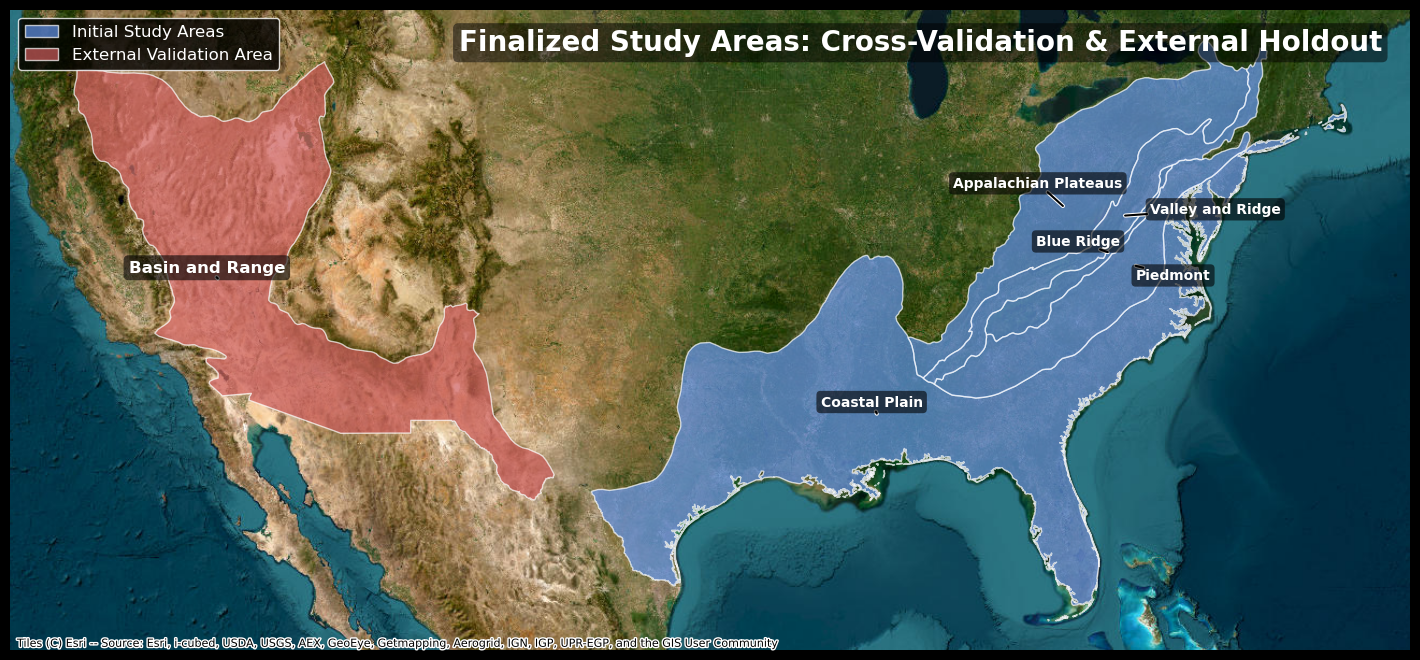

In [11]:
# === 7. Visual QA (Static Map) ===
log.info("Creating static map of final study areas...")

fig, ax = create_area_map(
    study_gdf=study_cv,
    validation_gdf=external_holdout,
    title="Finalized Study Areas: Cross-Validation & External Holdout",
    save_path=STATIC_MAP_PATH,
    basemap_provider=ctx.providers.Esri.WorldImagery
)
plt.show()


In [12]:
# === 8. Interactive Folium Map ===
log.info("Creating interactive map...")
m = create_interactive_map(
    study_gdf=study_cv,
    validation_gdf=external_holdout,
    save_path=INTERACTIVE_MAP_PATH
)
log.info(f"Interactive map saved -> {INTERACTIVE_MAP_PATH}")
m


2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - Creating interactive map...
✅ Interactive map saved to: D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\outputs\maps\study_areas_interactive_map.html
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - Interactive map saved -> D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\outputs\maps\study_areas_interactive_map.html


In [13]:
# === 9. Summary ===
log.info("✅ All data files exported successfully.")
log.info(f"CV provinces (all):   {STUDY_AREAS_GPKG_OUT} (layer='cv_provinces')")
log.info(f"External holdout:     {EXTERNAL_HOLDOUT_GPKG_OUT} (layer='external_holdout')")
log.info(f"LOPO folds GPKG:      {LOPO_GPKG} (per-fold train/test layers)")
log.info(f"LOPO manifest (CSV):  {LOPO_MANIFEST_CSV}")
log.info(f"Static map:           {STATIC_MAP_PATH}")
log.info(f"Interactive map:      {INTERACTIVE_MAP_PATH}")


2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - ✅ All data files exported successfully.
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - CV provinces (all):   D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\study_areas.gpkg (layer='cv_provinces')
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - External holdout:     D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\external_holdout.gpkg (layer='external_holdout')
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - LOPO folds GPKG:      D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_folds.gpkg (per-fold train/test layers)
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - LOPO manifest (CSV):  D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\lopo_manifest.csv
2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - Static map:           D:\OneDrive - University of Georgia\multis

In [14]:
# === 7. Create and Export Master AOI ===
log.info("--- Creating and Exporting Master AOI ---")

# Define the new output path from the config
MASTER_AOI_GPKG_OUT = PROJECT_ROOT / config['paths']['master_aoi']

# Concatenate the final, cleaned CV and Holdout GeoDataFrames
gdf_all_final = pd.concat([study_cv, external_holdout], ignore_index=True)

# Create the master AOI by dissolving everything into a single feature
master_aoi_geom = gdf_all_final.union_all()
master_aoi_gdf = gpd.GeoDataFrame(geometry=[master_aoi_geom], crs=PROCESSING_CRS)

# Add an attribute for clarity
master_aoi_gdf['name'] = 'master_aoi'

# Write the final Master AOI to a new GeoPackage
write_vector(master_aoi_gdf, MASTER_AOI_GPKG_OUT, layer='master_aoi', overwrite=True)
write_provenance(
    artifact_path=MASTER_AOI_GPKG_OUT,
    source_info={
        "cv_path": str(STUDY_AREAS_GPKG_OUT),
        "holdout_path": str(EXTERNAL_HOLDOUT_GPKG_OUT)
    },
    parameters={"description": "Union of all CV and external holdout provinces."}
)

log.info(f"✅ Master AOI saved successfully to: {MASTER_AOI_GPKG_OUT}")
display(master_aoi_gdf)

2025-10-18 21:51:58 - 1.1_finalize_study_areas - INFO - --- Creating and Exporting Master AOI ---
2025-10-18 21:51:59 - pyogrio._io - INFO - Created 1 records
2025-10-18 21:51:59 - geoio - INFO - Wrote D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\master_aoi.gpkg (GPKG:master_aoi)


S:\Temp\ipykernel_36024\605454546.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  master_aoi_geom = gdf_all_final.unary_union


2025-10-18 21:51:59 - provenance - INFO - Wrote provenance to master_aoi.gpkg.meta.json
2025-10-18 21:51:59 - 1.1_finalize_study_areas - INFO - ✅ Master AOI saved successfully to: D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\processed\master_aoi.gpkg


,geometry,name
0,"MULTIPOLYGON (((-120373 356595, -119140 336357...",master_aoi
